# WBAI Aphasia (Pure Alexia) Handson 01
<!-- green '#007879' -->

<br>
<div align='center'>
    <font size='+2' color='#0070FF' align='right'>17/Sep/2018</font><br><br>
<!--<font size='+2' color='#0070FF' align='center'><strong>浅川 伸一</strong> &lt;asakawa@ieee.org&gt;</font>-->
    <font size='+2' color='#0070FF' align='center'><strong><a href="http://www.cis.twcu.ac.jp/~asakawa/">浅川 伸一</a> &lt;asakawa@ieee.org&gt;</strong></font>
    <br><br>
</div>
<br>
<img src='https://wba-initiative.org/wp-content/uploads/2015/05/logo.png' width='29%' align='cener'>
<br>

<div>
<img src="./assets/Elman-portrait.jpg" width="49%" align='center'>
</div>

# SRN

SRN の基本は以下の式である。
\begin{equation}
\mathbf{y} = \sigma\left(\mathbf{Xw}_{in}+\mathbf{Hw}_{rec}+\mathbf{b}\right)
\end{equation}

ここで $\mathbf{X}$ はデータ行列で $n$ 行，$d$ 列 のデータ行列である。一時刻あたり一行のデータである。
時間発展を考えると $\mathbf{X}$ は逐次実行してまず $\mathbf{H}$ を作らなければならない。

---
- リカレントニューラルネットワークの本質として，一時刻前の情報を保持しておく機構がネットワーク内に存在していることが挙げられる。
- 時間展開した図

<center>
    <img src="./assets/unfolding_RNN.png" width="39%">
    <img src="./assets/2015Bullinaria_Unfolding.png" width="74%">
    </center>

In [82]:
# -*- coding: utf-8 -*-
#from __future__ import print_function
#from six.moves import range

import os
import sys
import time
import numpy as np
import codecs
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

import wbai_aphasia as handson
from wbai_aphasia import xavier_initializer
from wbai_aphasia import sigmoid, tanh, relu, elu, identity, softsign, softplus, sat, clu
from wbai_aphasia import fc_layer, softmax_layer, srn_layer
from wbai_aphasia import fetch_mnist, view_mnist
from wbai_aphasia import one_hot_vector, txt2data
#from wbai_aphasia import cost

In [2]:
!date; printf '\n'
!uname -a; printf '\n'
!type python; printf '\n'
!python --version; printf '\n'
!gcc --version; printf '\n'
!conda --version; printf '\n'

Mon Sep 17 03:42:54 JST 2018

Darwin Himalia.local 17.7.0 Darwin Kernel Version 17.7.0: Thu Jun 21 22:53:14 PDT 2018; root:xnu-4570.71.2~1/RELEASE_X86_64 x86_64

python is /Users/asakawa/anaconda3/bin/python

Python 3.6.6

Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/usr/include/c++/4.2.1
Apple LLVM version 9.1.0 (clang-902.0.39.2)
Target: x86_64-apple-darwin17.7.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin

conda 4.5.11



In [3]:
### preparation to draw graphs
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.set_printoptions(precision=3, suppress=True)
np.random.seed(seed=None)

In [4]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [88]:
class elman(object):
    """A simple elman network model demo.

    Parameters:
        hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
            The ith element represents the number of neurons in the ith
            hidden layer.

        activation : {identity, sigmoid, tanh, relu, elu, clu}, default tanh
            Activation function for the hidden layer.

        solver : {'sgd', 'adagrad', 'adadelta, 'rmsprop, 'adam', 'nadam'}, 
            default 'adam'.  The solver for weight optimization. 
            **NOT IMPLEMENTED**

        lambda_ : float, optional, default 1e-4
            L2 penalty (regularization term) parameter.

        lr : the learning ratio: float
        lr_init: float, default 1e-2
        
        random_state : int, RandomState instance or None, optional, default None
            If int, random_state is the seed used by the random number generator;
            If RandomState instance, random_state is the random number generator;
            If None, the random number generator is the RandomState instance used
            by `np.random`.

        tol : float, optional, default 1e-4
            Tolerance for the optimization. When the loss or score is not improving
            by at least tol for two consecutive iterations, unless `learning_rate`
            is set to 'adaptive', convergence is considered to be reached and
            training stops.

        verbose : bool, optional, default False
            Whether to print progress messages to stdout.

    """
    
    def __init__(self, X, y, \
                 n_hid=128, \
                 max_iter=1e+3, \
                 lr=1e-2, \
                 activation=tanh, \
                 verbose=False):
        self.max_iter = max_iter if max_iter is not None else 200
        self.n_hid = n_hid if n_hid is not None else 128
        self.X, self.y = np.copy(X), np.copy(y)
        self.activation = activation if activation is not None else tanh
        self.verbose = verbose if verbose is not None else False

        self.n_inp = self.X.shape[1]
        self.n_out = self.n_inp
        self.H = srn_layer(self.n_inp, self.n_hid, activation=activation)
        self.O = softmax_layer(self.n_hid, self.n_out)

    def fit(self, X, y, lr=1e-2, max_iter=1000, verbose=False):
        """Fit the model to data matrix X and target y.

        Parameters:
            X : array-like or sparse matrix, shape (n_samples, n_features)
                The input data.

            y : array-like, shape (n_samples,) or (n_samples, n_outputs)
                The target values (class labels in classification).

        Returns:
            self : returns a trained MLP model.
        """
        return self.train(X, y, max_iter=max_iter, verbose=verbose)

     
    def train(self, X, y, lr=1e-2, max_iter=1000, verbose=False):
        """Train the model to data matrix X and target y.

        Parameters:
            X : array-like or sparse matrix, shape (n_samples, n_features)
                The input data.

            y : array-like, shape (n_samples,) or (n_samples, n_outputs)
                The target values (class labels in classification).

        Returns:
            self : returns a trained the Elman network model.
        """
        X = self.X if X is None else X
        y = self.y if y is None else y
        verbose = verbose if verbose is not None else self.verbose
        max_iter = max_iter if max_iter is not None else self.max_iter
        hInit = np.zeros((1, self.n_hid),dtype=np.float32)
        state = np.zeros((X.shape[0],self.n_hid),dtype=np.float32)
        lossList = list()
        for t in range(max_iter):
            inp = X
            Hout, state = self.H.forward(X, state, hInit)
            y_ = self.O.forward(Hout)

            Err = y_ - y
            #loss = np.mean(Err**2)
            loss = handson.binary_log_loss(y,y_)
            lossList.append(loss)
            if (t % (max_iter>>3) == 0) and verbose:
                #print('Iter={0:05d} loss={1:0.3f}'.format(iter, loss))
                p = np.argmax(y,axis=0)
                p_ = np.argmax(y_,axis=0)
                accuracy = np.average(p == p_)
                print('Iter={0:05d} loss={1:0.4f}, cost={2:0.4f}, accuracy={3:0.4f}'.format(
                    t, 
                    loss,
                    handson.cost(y_),
                    accuracy))
            delta = Err
            gradW2 = self.O.backward(delta, Hout)
            delta = np.dot(delta, self.O.W.T)
            gradW1, gradWr, _ = self.H.backward(X, state, delta)
    
            self.O.W -= lr * gradW2
            self.O.bias -= lr * np.mean(gradW2)
            self.H.W -= lr * gradW1
            self.H.bias -= lr * np.mean(gradW1)
            self.H.Wr -= lr * gradWr
        
        if verbose:
            plt.plot(lossList)
            #plt.show()
            print('#Target: ', end='')
            for x in y:
                print(idx2wrd[np.argmax(x)],end='')
            print('\n#Output: ', end='')
            for x in y_:
                print(idx2wrd[np.argmax(x)],end='')
            print()    
            
        return y_, lossList

    
    def predict(self, X):
        """Predict using this elman neural network.

        Parameters:
            X : {array-like, matrix}, shape (n_samples, n_features)
            The input data.

        Returns:
            y : array-like, shape (n_samples,) or (n_samples, n_classes)
            The predicted classes.
        """

        hInit = np.zeros((1, self.n_hid),dtype=np.float32)
        state = np.zeros((X.shape[0],self.n_hid),dtype=np.float32)
        Hout, state = self.H.forward(X, state, hInit)
        y_ = self.O.forward(Hout)
        return y_

    
    def predict_log_prob(self, X):
        """Return the log of probability estimates.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                The input data.

        Returns:
            log_y_prob : array-like, shape (n_samples, n_classes)
                The predicted log-probability of the sample for each class
                in the model, where classes are ordered as they are in
                `self.classes_`. Equivalent to log(predict_proba(X))
        """
        yprob_ = self.predict_prob(X)
        return np.log(yprob_, out=yprob_)

    def predict_prob(self, X):
        """Probability estimates.

        Parameters:
            X : {array-like, sparse matrix}, shape (n_samples, n_features)
                The input data.

        Returns:
            y_prob : array-like, shape (n_samples, n_classes)
                The predicted probability of the sample for each class in the
                model, where classes are ordered as they are in `self.classes_`.
        """
        y_ = self._predict(X)

        if self.n_outputs_ == 1:
            y_ = y_.ravel()

        if y_.ndim == 1:
            return np.vstack([1 - y_, y_]).T
        else:
            return y_


filename=basyo.txt
Iter=00000 loss=5.9167, cost=4.9252, accuracy=0.0000
Iter=00125 loss=2.0057, cost=7.4214, accuracy=0.3556
Iter=00250 loss=1.7492, cost=8.9311, accuracy=0.3556
Iter=00375 loss=1.7292, cost=9.5244, accuracy=0.3630
Iter=00500 loss=1.7245, cost=9.8053, accuracy=0.3556
Iter=00625 loss=1.7549, cost=9.9707, accuracy=0.3556
Iter=00750 loss=1.7295, cost=9.9695, accuracy=0.3630
Iter=00875 loss=1.7442, cost=9.8522, accuracy=0.3704
#Target: 日は百代の過客にして、行き交ふ年もまた旅人なり。船の上に生涯を浮かべ、馬の口とらへて老いを迎ふる者は、日々旅にして旅を栖とす。古人も多く旅に死せるあり。</s>予もいづれの年よりか、片雲の風に誘はれて、漂白の思ひやまず、海浜にさすらへ、去年の秋、江上の破屋に蜘蛛の古巣をはらひて、やや年も暮れ、春立てる霞の空に、白河の関越えんと、そぞろ神の物につきて心を狂はせ、道祖神の招きにあひて取るもの手につかず、股引の破れをづづり、笠の緒付けかへて、三里に灸すゆるより、松島の月まづ心にかかりて、住める方は人に譲り、杉風が別所に移るに、</s></s>草の戸も住み替はる代ぞ雛の家</s></s>表八句を庵の柱に掛け置く。</s>月
#Output: 日々人代の破客につて、江き交ふ年もいず旅にもり、</s>の破につ涯を栖かり、江の破とすへて、いづ栖ふ年方は人江々旅につて、に栖とすゆ</s>巣もいく。につせ、方ひ、</s></s>もいづれ、破もり、り江雲の破がつは人、、江白河破ひて年ず、江浜につすゆへて江年も破、江上に破れにつ蛛の破巣を栖人へて、江年年もいれ、江立て、方の破につ江河の破越えんとす江ぞろ神の破につか交、を栖は人、江祖神の破き交つひて、る方い破につかり、江引の破れ、栖れれ、江の破付けかり

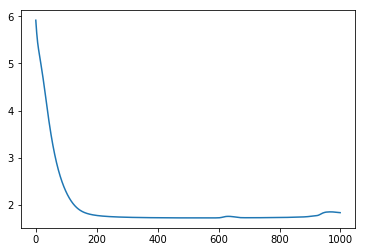

In [92]:
filename = 'j_constitution9.txt'
filename = 'basyo.txt'
nHid = 128
activation = tanh
max_iter = 1000
lr = 1e-2
X, y, idx2wrd, wrd2idx = txt2data(filename)
model = elman(X, y, n_hid=nHid, lr=lr, max_iter=max_iter, activation=activation)
start_time = time.time()
y_, lossList = model.train(X, y, max_iter=max_iter,verbose=True)
#y_, _ = model.fit(X, y, max_iter=max_iter, verbose=True)
end_time = time.time()
print('time elasped {}'.format(end_time - start_time))

In [ ]:
def main(filename=None, max_iter=1000, nHid=16, activation=tanh, lr=1e-2, verbose=False):
    X, y, idx2wrd, wrd2idx = txt2data(filename)
    model = elman(X, y, n_hid=nHid, lr=lr, max_iter=max_iter, activation=tanh, verbose=verbose)
    y_, lossList = model.train(X, y, max_iter=max_iter, verbose=verbose)
    
    return model, X, y_, lossList, idx2wrd, wrd2idx

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Simple demo for both MLP and SRN')
    parser.add_argument('--seed', type=int, default=1, help='# Seed number to gerenrate random number sequence.')
    parser.add_argument('--max_iter', type=int, default=1000, help='# maximum number of iteration.')
    parser.add_argument('--nHid', type=int, default=32, help='# The number of the hidden unints.')
    parser.add_argument('--lr', type=float, default=1e-2, help='# Learning ratio.')
    parser.add_argument('--activation', default='tanh', help='# activation function')
    #parser.add_argument('--filename', default=__file__, help='# The input text file name')
    parser.add_argument('--filename', default='j_constitution9.txt', help='# The input text file name')
    parser.add_argument('--verbose', action='store_false', help='# Verbose flag for debug')

    args = parser.parse_args()
    if args.seed:
        seed = args.seed
    if args.max_iter:
        max_iter = args.max_iter
    if args.nHid:
        nHid = args.nHid
    if args.lr:
        lr = args.lr
    if args.activation:
        activation=args.activation
    if args.filename:
        filename=args.filename
    if args.verbose:
        verbose=True

    main(filename=filename, max_iter=max_iter, nHid=nHid, activation=activation, lr=lr, verbose=verbose)